### This file will have code to run different versions of logistic regression in managed fashion

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.typing as npt
from typing import Callable

np.random.seed(16)

Generate Dataset & update dataset

In [2]:
def generate_data(n, k, num_outliers = 0, outlier_both = True):
    if outlier_both:
        n = n - (num_outliers * 2)
    nneg, npos = n // 2, n - n // 2
    if num_outliers > 0 and not outlier_both:
        nneg = nneg - num_outliers
    X_pos = np.random.uniform(1, 5, size=(npos, k))
    X_neg = np.random.uniform (-5, -1, size=(nneg, k))
    # loc = 2.0 # mean
    # scale = 0.5 # standard deviation
    # X_pos = np.random.normal(loc, scale, size=(npos, k)) + np.full((npos, k), 3.0)
    # X_neg = np.random.normal(loc, scale, size=(nneg, k)) + np.full((nneg, k), -3.0)
    if outlier_both:
        outlier_pos = np.random.uniform(-8, -3, size=(num_outliers, k))
        X_pos = np.vstack((X_pos, outlier_pos))
    if num_outliers > 0:
        outlier_neg = np.random.uniform(3, 8, size=(num_outliers, k))
        X_neg = np.vstack((X_neg, outlier_neg))
    
    X = np.vstack((X_pos, X_neg))
    y = np.hstack((np.ones(X_pos.shape[0]), np.zeros(X_neg.shape[0])))
    return X, y

def normalise_dataset(X, type='minmax'):
    if type == 'minmax':
        X = (X - X.min()) / (X.max() - X.min())
    elif type == 'zscore':
        X = (X - X.mean()) / X.std()
    elif type == 'unit':
        X = X / np.linalg.norm(X)
    return X

def split_dataset(X, y, split_ratio=0.8):
    n = X.shape[0]
    n_train = int(n * split_ratio)
    idx = np.random.permutation(n)
    idx_train = idx[:n_train]
    idx_test = idx[n_train:]
    X_train, y_train = X[idx_train], y[idx_train]
    X_test, y_test = X[idx_test], y[idx_test]
    return X_train, y_train, X_test, y_test

def generate_batch(X, y, batch_size):
    n = X.shape[0]
    iter = n // batch_size
    idx = np.random.permutation(n)
    for i in range(iter):
        idx_batch = idx[i*batch_size:(i+1)*batch_size]
        X_batch, y_batch = X[idx_batch], y[idx_batch]
        yield X_batch, y_batch

def augment_data(X):
    n = X.shape[0]
    X_aug = np.hstack((np.ones((n, 1)), X))
    return X_aug

#### Plot dataset

In [3]:
def plot_dataset(X, y, theta = []):
    plt.figure(figsize=(8, 8))
    plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='o', c='b',  label='Positive')
    plt.scatter(X[y == 0, 0], X[y == 0, 1],marker='x', c='r', label='Negative')

    if len(theta) > 0:
        x_line = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
        y_line = -(theta[0] + theta[1] * x_line) / theta[2]
        plt.plot(x_line, y_line, color='black', linestyle='-', label='Classification Line')

def plot_loss(loss):
    plt.figure(figsize=(8, 8))
    plt.plot(loss)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss vs Iteration')
    plt.show()

def plot_accuracy(acc):
    plt.figure(figsize=(8, 8))
    plt.plot(acc)
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Iteration')
    plt.show()

def plot_heatmap(cnf_matrix):
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [21]:
X, y = generate_data(100, 2,10, outlier_both=False)
print(X.shape, y.shape)

(100, 2) (100,)


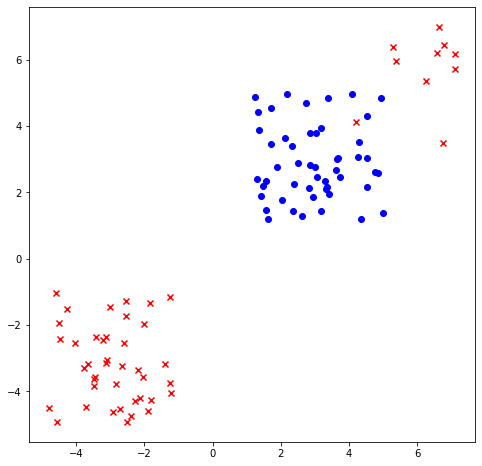

In [22]:
plot_dataset(X, y)

## Method 3 -- Naives Bayes Classifier

[0. 1.]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
1 [0.]
Number of wrong predictions:  1


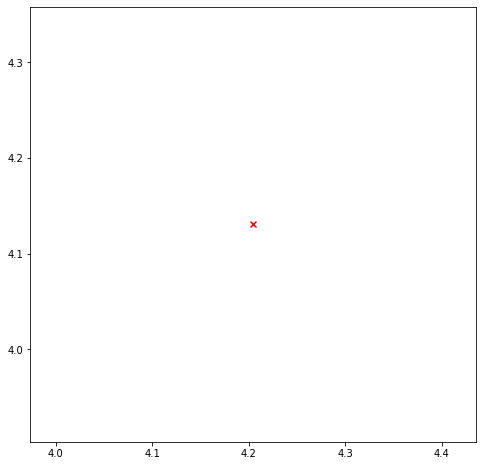

In [23]:
from classification.naive_bayes_classification import NBC

nbc = NBC(feature_types=['r', 'r'], num_classes=2)
nbc.fit(X, y)
y_pred = nbc.predict(X)
print(y_pred)
y_not_match = y_pred != y
print(y_not_match.sum(), y[y_not_match])
X_wrong_pred = X[y_pred != y]
y_wrong_pred = y[y_pred != y]
print("Number of wrong predictions: ", X_wrong_pred.shape[0])
plot_dataset(X_wrong_pred, y_wrong_pred)

In [24]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X, y)
y_pred = gnb.predict(X)
print(y_pred)
y_not_match = y_pred != y
print(y_not_match.sum(), y[y_not_match])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0.]
1 [0.]


## Method 1 -- Logistic Regression using Logistic Function

In [43]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def cost_function(theta, X, y):
    n = X.shape[0]
    y_pred = sigmoid(X.dot(theta))
    cost = -1 / n * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
    return cost

def sigmoid_derivative(z):
    return sigmoid(z) * (1 - sigmoid(z))

def gradient_descent(theta, X, y, alpha, num_iters):
    n = X.shape[0]
    J_history = np.zeros(num_iters)
    J_accuracy = np.zeros(num_iters)
    best_theta = theta
    best_accuracy = 0
    for i in range(num_iters):
        y_pred = sigmoid(X.dot(theta))
        theta = theta - alpha * 1 / n * X.T.dot(y_pred - y)
        J_history[i] = cost_function(theta, X, y)
        J_accuracy[i] = calculate_accuracy(theta, X, y)
        if best_accuracy < J_accuracy[i]:
            best_accuracy = J_accuracy[i]
            best_theta = theta

    return best_theta, J_history, J_accuracy

def calculate_accuracy(theta, X, y):
    y_pred = sigmoid(X.dot(theta))
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0
    return np.mean(y_pred == y)

def get_wrong_prediction(theta, X, y):
    X_train = augment_data(X)
    y_pred = sigmoid(X_train.dot(theta))
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0
    X_wrong_pred = X[y_pred != y]
    y_wrong_pred = y[y_pred != y]
    print("Number of wrong predictions: ", X_wrong_pred.shape[0])
    plot_dataset(X_wrong_pred, y_wrong_pred, theta)

In [10]:
def cost_function_sigmoid_mean_square(theta: npt.NDArray, X: npt.NDArray, y: npt.NDArray):
    n = X.shape[0]
    y_pred = sigmoid(X.dot(theta))
    cost = 1 / n * np.sum(np.square(y_pred - y))
    return cost

def logistic_mean_square_gradient(X: npt.NDArray, y_pred: npt.NDArray, y: npt.NDArray):
    n = X.shape[0]
    return 2 / n * X.T.dot((y_pred - y) * (y_pred * (1 - y_pred)))

def normalised_gradient_descent(theta, X, y, alpha, num_iters):
    n = X.shape[0]
    J_history = np.zeros(num_iters)
    J_accuracy = np.zeros(num_iters)
    best_theta = theta
    best_accuracy = 0
    for i in range(num_iters):
        y_pred = sigmoid(X.dot(theta))
        gradient = logistic_mean_square_gradient(X, y_pred, y)
        normalised = np.linalg.norm(gradient) + 1e-8
        gradient = gradient / normalised
        theta = theta - alpha * gradient
        J_history[i] = cost_function_sigmoid_mean_square(X, y, theta)
        J_accuracy[i] = calculate_accuracy(theta, X, y)
        if best_accuracy < J_accuracy[i]:
            best_accuracy = J_accuracy[i]
            best_theta = theta

    return best_theta, J_history, J_accuracy

In [60]:
X_train = augment_data(X)
# xavier initialization of thetas
theta = np.random.uniform(-1, 1, size=X_train.shape[1])

alpha = 0.01
num_iters = 100
# theta, J_history, J_accuracy = gradient_descent(theta, X_train, y, alpha, num_iters)
theta, J_history, J_accuracy = normalised_gradient_descent(theta, X_train, y, alpha, num_iters)

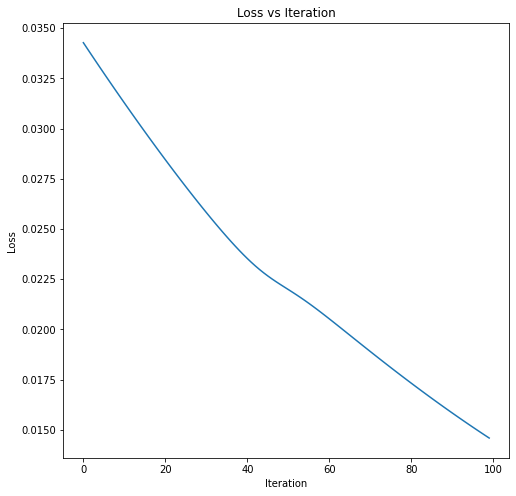

In [61]:
plot_loss(J_history)

0.8


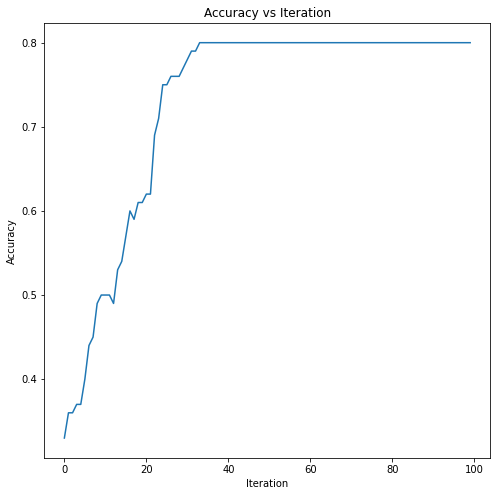

In [62]:
print(calculate_accuracy(theta, X_train, y))
plot_accuracy(J_accuracy)

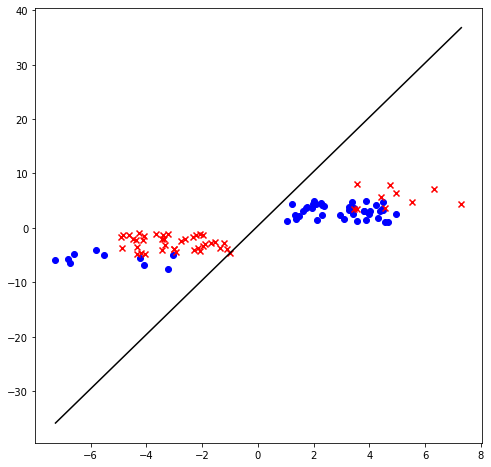

In [63]:
plot_dataset(X, y, theta)

Number of wrong predictions:  20


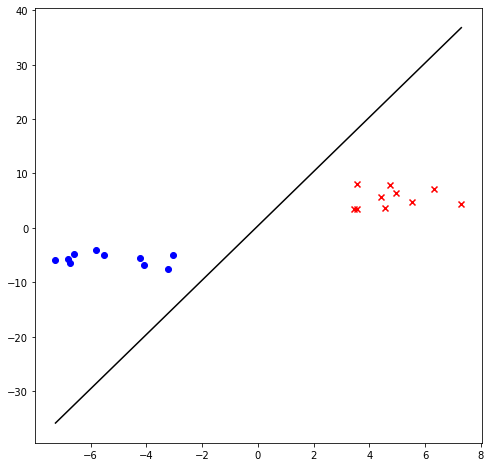

In [64]:
get_wrong_prediction(theta, X, y)

In [ ]:
z = np.linspace(-8, 8, 100)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(z, sigmoid(z), 'b-')
ax.set_xlabel('$z$', fontsize=12)
ax.set_ylabel('$\sigma(z)$', fontsize=12)
ax.set_title('logistic function')
ax.set_xlim(-8, 8)
plt.show()

In [ ]:
#### Try one optimisation using Newton's method

In [ ]:
### Using sklearn library for logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)
# fit the model with data
logreg.fit(X, y)
# Get the coefficients (thetas) for each feature
thetas = logreg.coef_
# Get the intercept
intercept = logreg.intercept_
theta = np.hstack((intercept, thetas[0]))
y_pred = logreg.predict(X)


In [ ]:
print(theta)
print(thetas)
print(intercept)
print(X_train.shape)

In [ ]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y, y_pred)
plot_heatmap(cnf_matrix)

In [ ]:
get_wrong_prediction(theta, X, y), plot_dataset(X, y, theta)

### try one with hyperbolic tangent function

In [137]:
# for tangent, labels are -1 and 1
def tangent(x: npt.NDArray):
    x = np.clip(x, -740, 700)
    y_pred = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
    output = 0.5 * (y_pred + 1)
    return y_pred, output

def tangent_derivative(x:npt.NDArray):
    return 1 - np.square(tangent(x))

def cost_function_tang(X: npt.NDArray, y: npt.NDArray, theta: npt.NDArray):
    n = X.shape[0]
    y_pred, output = tangent(X.dot(theta))
    y_pred = np.clip(y_pred, 1e-7, None)
    cost = -1 / n * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
    return cost

def tangent_gradient1(X: npt.NDArray, y: npt.NDArray, theta: npt.NDArray):
    n = X.shape[0]
    z = X.dot(theta)
    y_pred = tangent(z)
    y_pred = np.clip(y_pred, 1e-7, 1- 1e-7)
    # update this too sigmoid one (y_pred - y) * X
    tmp = np.dot(X.T, (y_pred - y))
    # gradient = np.dot(X.T, tmp)
    return tmp / n

def tangent_gradient2(X: npt.NDArray, y: npt.NDArray, theta: npt.NDArray):
    n = X.shape[0]
    z = X.dot(theta)
    y_pred, output = tangent(z)
    # y_pred = np.clip(y_pred, -1e-7, None)
    # Gradient of the loss function with respect to the i-th weight using tanh activation
    gradient = (((y/y_pred) * -1) + (1 - y)/(1 - y_pred)) * (1 - y_pred**2)
    gradient = np.dot(X.T, gradient)
    return gradient / n

def calculate_accuracy_tang(theta: npt.NDArray, X: npt.NDArray, y: npt.NDArray, activation : Callable):
    y_pred,output = activation(X.dot(theta))
    output[output >= 0.5] = 1
    output[output < 0.5] = 0
    return np.mean(output == y)

## Tangent L2 loss

In [73]:
# for tangent, labels are -1 and 1
# def tangent(x: npt.NDArray):
#     x = np.clip(x, 1e-5, 700)
#     return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

# def tangent_derivative(x:npt.NDArray):
#     return 1 - np.square(tangent(x))

def cost_function_tang_l2(X: npt.NDArray, y: npt.NDArray, theta: npt.NDArray, lambda_: float):
    n = X.shape[0]
    y_pred = tangent(X.dot(theta))
    y_pred = np.clip(y_pred, 1e-5, None)
    cost = 1 / n * np.sum(np.square(y_pred - y))
    return cost

def tangent_gradient(X: npt.NDArray, y: npt.NDArray, theta: npt.NDArray):
    n = X.shape[0]
    z = X.dot(theta)
    y_pred = tangent(z)
    gradient = np.dot(X.T, (y - y_pred) * (1 - y_pred ** 2))
    return 2 * (gradient / n)

def calculate_accuracy_tang(theta: npt.NDArray, X: npt.NDArray, y: npt.NDArray, activation : Callable):
    y_pred = activation(X.dot(theta))
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0
    return np.mean(y_pred == y)

In [138]:
def gradient_descent(theta, X, y, alpha, num_iters, activation_gradient: Callable, activation: Callable):
    n = X.shape[0]
    J_history = np.zeros(num_iters)
    J_accuracy = np.zeros(num_iters)
    best_theta = theta
    best_accuracy = 0
    for i in range(num_iters):
        # y_pred = activation(X.dot(theta))
        theta = theta - alpha * activation_gradient(X, y, theta)
        J_history[i] = cost_function_tang(X, y, theta)
        J_accuracy[i] = calculate_accuracy_tang(theta, X, y, activation)
        if best_accuracy < J_accuracy[i]:
            best_accuracy = J_accuracy[i]
            best_theta = theta

    return best_theta, J_history, J_accuracy

In [154]:
# try with normalising input
X_train = augment_data(X)
# xavier initialization of thetas
theta_ori = np.random.uniform(-1, 1, size=X_train.shape[1])
alpha = 0.01
num_iters = 100

In [150]:
theta

array([-0.11965691,  0.98513319,  0.33273071])

In [149]:
theta, J_history, J_accuracy = gradient_descent(theta_ori, X_train, y, alpha, num_iters, tangent_gradient2, tangent)

In [ ]:
theta, J_accuracy

In [ ]:
J_history

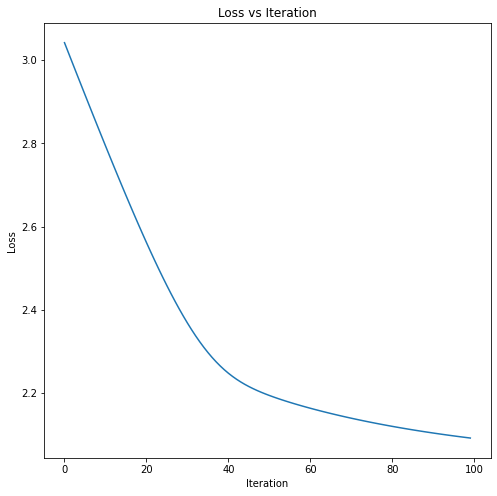

(None, None)

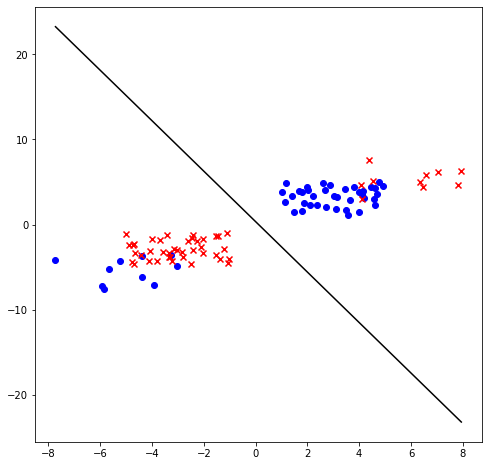

In [152]:
plot_loss(J_history), plot_dataset(X, y, theta)

In [ ]:
theta, J_history, J_accuracy = gradient_descent(theta_ori, X_train, y, alpha, num_iters, tangent_gradient1, tangent)

In [ ]:
theta

In [ ]:
plot_loss(J_history), plot_dataset(X, y, theta)

In [ ]:
theta, J_history, J_accuracy = gradient_descent(theta_ori, X_train, y, alpha, num_iters, tangent_gradient2, tangent)

In [ ]:
theta

In [ ]:
plot_loss(J_history), plot_dataset(X, y, theta)

In [155]:
def cost_function_tang_mean_square(X: npt.NDArray, y: npt.NDArray, theta: npt.NDArray):
    n = X.shape[0]
    y_pred, _ = tangent(X.dot(theta))
    cost = 1 / n * np.sum(np.square(y_pred - y))
    return cost

def tangent_mean_square_gradient(X: npt.NDArray, y_pred: npt.NDArray, y: npt.NDArray):
    n = X.shape[0]
    return 2 / n * X.T.dot((y_pred - y) * (1 - y_pred**2))

def calculate_accuracy_tang(theta: npt.NDArray, X: npt.NDArray, y: npt.NDArray, activation : Callable):
    _, output = activation(X.dot(theta))
    output[output >= 0.5] = 1
    output[output < 0.5] = 0
    return np.mean(output == y)

def normalised_gradient_descent_tangent(theta, X, y, alpha, num_iters, activation: Callable):
    n = X.shape[0]
    J_history = np.zeros(num_iters)
    J_accuracy = np.zeros(num_iters)
    best_theta = theta
    best_accuracy = 0
    for i in range(num_iters):
        y_pred = sigmoid(X.dot(theta))
        gradient = tangent_mean_square_gradient(X, y_pred, y)
        normalised = np.linalg.norm(gradient) + 1e-8
        gradient = gradient / normalised
        theta = theta - alpha * gradient
        J_history[i] = cost_function_tang_mean_square(X, y, theta)
        J_accuracy[i] = calculate_accuracy_tang(theta, X, y, activation)
        if best_accuracy < J_accuracy[i]:
            best_accuracy = J_accuracy[i]
            best_theta = theta

    return best_theta, J_history, J_accuracy

In [156]:
theta, J_history, J_accuracy = normalised_gradient_descent_tangent(theta_ori, X_train, y, alpha, num_iters, tangent)

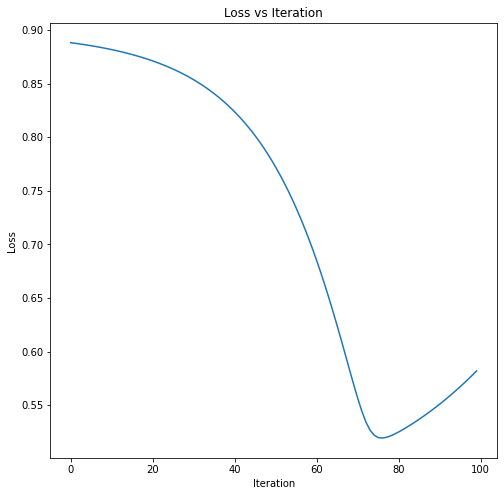

(None, None)

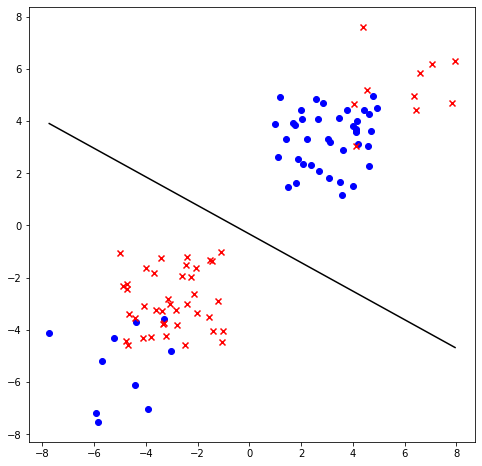

In [157]:
plot_loss(J_history), plot_dataset(X, y, theta)

In [ ]:
import numpy as np

class CustomLogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def binary_cross_entropy(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def fit(self, X, y):
        m, n = X.shape
        self.thetas = np.random.rand(n)

        for _ in range(self.num_iterations):
            z = np.dot(X, self.thetas)
            y_pred = self.tanh(z)
            loss = self.binary_cross_entropy(y, y_pred)

            gradient = np.dot(y * self.tanh_derivative(z), X) - np.dot((1 - y) * self.tanh_derivative(z), X)
            self.thetas = self.thetas - (self.learning_rate / m) * gradient

    def predict(self, X):
        z = np.dot(X, self.thetas)
        y_pred = self.tanh(z)
        return np.round(y_pred)

In [ ]:
# Example usage
# from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create and train the custom logistic regression model
model = CustomLogisticRegression()
model.fit(X_train, y)

# Predict
y_pred = model.predict(X_train)

# Calculate accuracy
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy}")


In [ ]:
y_pred = tangent(X_train.dot(model.thetas))
print(y_pred)
y_pred[y_pred >= 0.1] = 1
y_pred[y_pred < 0.1] = -1
print(np.mean(y_pred == y))
# print(y_pred)

In [ ]:
plot_dataset(X, y, model.thetas)